<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>(2)

In [96]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

# 1. Reading Data

In [97]:
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


# 2. Similarity measures

## 2.1 Jaccard Distance:
http://www.statisticshowto.com/jaccard-index/

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [57]:
#set(train_graph.successors(a)) will return followees of a
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [58]:
#one test case
print(jaccard_for_followees(273084,1505602))

0.0


In [59]:
#node 1635354 not in graph 
print(jaccard_for_followees(273084,1505602))

0.0


In [11]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [60]:
print(jaccard_for_followers(273084,470294))

0


In [61]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))

0


## 2.2 Cosine distance

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [62]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [63]:
print(cosine_for_followees(273084,1505602))

0.0


In [64]:
print(cosine_for_followees(273084,1635354))

0


In [65]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [66]:
print(cosine_for_followers(2,470294))

0.02886751345948129


In [67]:
print(cosine_for_followers(669354,1635354))

0


## 3. Ranking Measures

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

<img src='PageRanks-Example.jpg'/>

Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. <b>(The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.</b>

## 3.1 Page Ranking

https://en.wikipedia.org/wiki/PageRank


In [68]:
if not os.path.isfile('data/fea_sample/page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('data/fea_sample/page_rank.p','wb'))
else:
    pr = pickle.load(open('data/fea_sample/page_rank.p','rb'))  # will return a dictionary containing node: prvalue

In [70]:
print('min',pr[min(pr, key=pr.get)])  # will return minimum pr values
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 1.6556497245737814e-07
max 2.7098251341935827e-05
mean 5.615699699389075e-07


In [71]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.615699699389075e-07


# 4. Other Graph Features

## 4.1 Shortest path:

Getting Shortest path between twoo nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path. 

In [72]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)   #if an edge is present remove it as we donot need direct links
            p= nx.shortest_path_length(train_graph,source=a,target=b) #computing shorter distance to b
            train_graph.add_edge(a,b)  #add the edge that we removed earlier
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [0]:
#testing
compute_shortest_path_length(77697, 826021)

10

In [0]:
#testing
compute_shortest_path_length(669354,1635354)

-1

## 4.2 Checking for same community

In [73]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))   # eg: contains [{22,34,2},{1,5,6},{1,2},{4,5}]
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):  #if there is a direct  link between b to a then they are in same 'weakly connected component'
        return 1
    if train_graph.has_edge(a,b):   
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [74]:
belongs_to_same_wcc(861, 1659750)

0

In [75]:
belongs_to_same_wcc(669354,1635354)

0

## 4.3 Adamic/Adar Index:
Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [76]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [77]:
calc_adar_in(1,189226)

0

In [78]:
calc_adar_in(669354,1635354)

0

## 4.4 Is persion was following back:

In [79]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [80]:
follows_back(1,189226)

1

In [81]:
follows_back(669354,1635354)

0

## 4.5 Katz Centrality:
https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/
 Katz centrality computes the centrality for a node 
    based on the centrality of its neighbors. It is a 
    generalization of the eigenvector centrality. The
    Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.

The parameter $$\beta$$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$

In [82]:
if not os.path.isfile('data/fea_sample/katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('data/fea_sample/katz.p','wb'))
else:
    katz = pickle.load(open('data/fea_sample/katz.p','rb'))

In [0]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007313532484065916
max 0.003394554981699122
mean 0.0007483800935562018


In [0]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483800935562018


## 4.6 Hits Score
The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

https://en.wikipedia.org/wiki/HITS_algorithm

In [0]:
if not os.path.isfile('data/fea_sample/hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('data/fea_sample/hits.p','wb'))
else:
    hits = pickle.load(open('data/fea_sample/hits.p','rb'))

In [0]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.004868653378780953
mean 5.615699699344123e-07


# 5. Featurization

## 5. 1 Reading a sample of Data from both train and test

In [83]:
import random
if os.path.isfile('data/after_eda/train_after_eda.csv'):
    filename = "data/after_eda/train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

In [84]:
if os.path.isfile('data/after_eda/train_after_eda.csv'):
    filename = "data/after_eda/test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

In [85]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


In [86]:
df_final_train = pd.read_csv('data/after_eda/train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('data/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,1011666,450550,1


In [87]:
df_final_test = pd.read_csv('data/after_eda/test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('data/test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,213034,758058,1


## 5.2 Adding a set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

In [88]:
if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
    #mapping jaccrd followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

        #mapping jaccrd followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [0]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [0]:
if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('data/fea_sample/storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'test_df',mode='r')

## 5.3 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [118]:
if not os.path.isfile('data/fea_sample/storage_sample_stage2.h5'):
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore('data/fea_sample/storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'test_df',mode='r')

## 5.4 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>

#### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

it is directed graph so calculated Weighted in and Weighted out differently

In [0]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|████████████████████████████████████████████████████████████████████| 1780722/1780722 [00:11<00:00, 152682.24it/s]


In [0]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [0]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('data/fea_sample/storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'test_df',mode='r')

## 5.5 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>SVD features for both source and destination</li>
</ol>

In [0]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [0]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [0]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [0]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [239]:
if not os.path.isfile('data/fea_sample/storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore('data/fea_sample/storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

## 5.6 Adding more features

### Preferential Attachment

In [209]:
def pref_attachment(a,b):
    try:
        pi1 = len(set(train_graph.neighbors(a)))
        pi2 = len(set(train_graph.neighbors(b)))
        return pi1 * pi2
    except:
        return 0
    

In [120]:
print(pref_attachment(23877,7483))

6


### Dot svd

In [210]:
# we wil take the dot product of source and destination of svd features obtained earliers
def dotproduct(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.dot(x,y)

In [240]:
if not os.path.isfile('storage_sample_stage_extrafeat.h5'):
    
    # applying preferential_attach
    df_final_train['preferential_attach'] = df_final_train.apply(lambda row: pref_attachment(row['source_node'],row['destination_node']),axis=1)
    df_final_test['preferential_attach'] = df_final_test.apply(lambda row: pref_attachment(row['source_node'],row['destination_node']),axis=1)
    #applying dot product
    #applying on train data
    df_final_train['dot_u'] = df_final_train.apply(lambda row: dotproduct(row[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4','svd_u_s_5', 'svd_u_s_6']],row[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3','svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']]), axis=1)
    df_final_train['dot_v'] = df_final_train.apply(lambda row: dotproduct(row[['svd_v_s_1', 'svd_v_s_2','svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']],row[['svd_v_d_1','svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']]),axis=1)
    #applying on test data
    df_final_test['dot_u'] = df_final_test.apply(lambda row: dotproduct(row[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4','svd_u_s_5', 'svd_u_s_6']],row[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3','svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']]), axis=1)
    df_final_test['dot_v'] = df_final_test.apply(lambda row: dotproduct(row[['svd_v_s_1', 'svd_v_s_2','svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']],row[['svd_v_d_1','svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']]),axis=1)
    #df_final_train.fillna(value=0,inplace=True)  #because dot product returning some null values
    #df_final_test.fillna(value=0,inplace=True)
    
    hdf = HDFStore('storage_sample_stage_extrafeat.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

## Tsne visualization

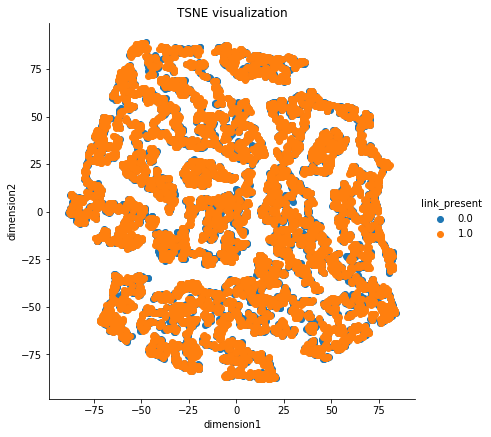

In [275]:
df_final_train = read_hdf('storage_sample_stage_extrafeat.h5', 'train_df',mode='r')
from sklearn.manifold import TSNE
df = df_final_train.loc[np.random.permutation(df_final_train.index)[:15000]]
dftsne = df
y_t = df['indicator_link']
tsne = TSNE(n_components=2,perplexity=30)
tsne_result = tsne.fit_transform(dftsne)
#tsne result will appear as 2 columns.We have to plot it
# creating a new data frame which help us in ploting the tsne_result
tsne_new = np.vstack((tsne_result.T,y_t)).T
df = pd.DataFrame(data=tsne_new, columns=("dimension1", "dimension2","link_present"))
# Ploting the result
sns.FacetGrid(df, hue="link_present", size=6).map(plt.scatter, 'dimension1','dimension2').add_legend()
plt.title("TSNE visualization")
plt.show()

Doesn't make much sense as it is overlapping

# ML Models

In [241]:
df_final_train = read_hdf('storage_sample_stage_extrafeat.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage_extrafeat.h5', 'test_df',mode='r')

In [252]:
df_final_train.columns

Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'preferential_attach', 'dot_u', 'dot_v'],
      dtype='object')

In [243]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [244]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

## Random Forest

Estimators =  10 Train Score 0.9157749540210667 test Score 0.9081272084805653
Estimators =  50 Train Score 0.9185857930587091 test Score 0.9138093938312302
Estimators =  100 Train Score 0.9194466535515465 test Score 0.9142905135850167
Estimators =  250 Train Score 0.9215940453290961 test Score 0.916610710088971
Estimators =  450 Train Score 0.9220862038324429 test Score 0.9172421030538357


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

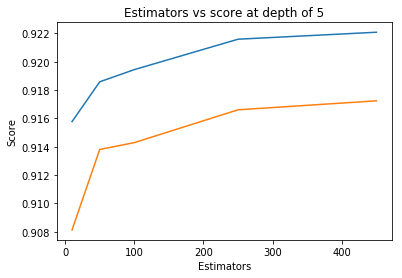

In [245]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8894081160088433 test Score 0.871252129471891
depth =  9 Train Score 0.9580315426519495 test Score 0.9233788431914579
depth =  11 Train Score 0.9606315232650403 test Score 0.9242960714887877
depth =  15 Train Score 0.9632293190313669 test Score 0.9259259259259259
depth =  20 Train Score 0.963307220846694 test Score 0.926167437946992
depth =  35 Train Score 0.9631748736989469 test Score 0.9262927680693122
depth =  50 Train Score 0.9631748736989469 test Score 0.9262927680693122
depth =  70 Train Score 0.9631748736989469 test Score 0.9262927680693122
depth =  130 Train Score 0.9631748736989469 test Score 0.9262927680693122


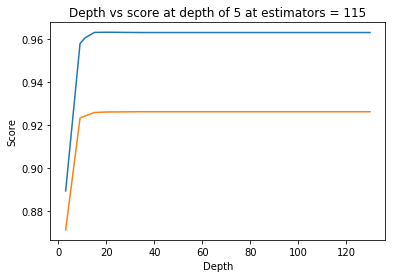

In [246]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [247]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])
print(rf_random.best_estimator_)

mean test scores [0.96210923 0.96170195 0.96021387 0.96158567 0.96301674]
mean train scores [0.96277298 0.96231884 0.96070164 0.96220443 0.96402097]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)


In [248]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9638355662709434
Test f1 score 0.9259220165086872


Train confusion_matrix


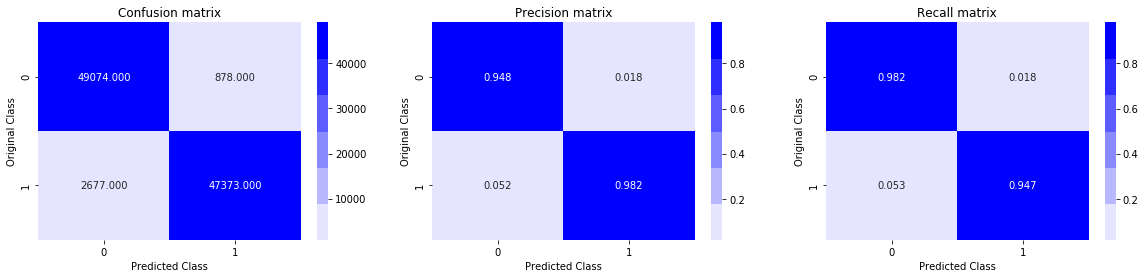

Test confusion_matrix


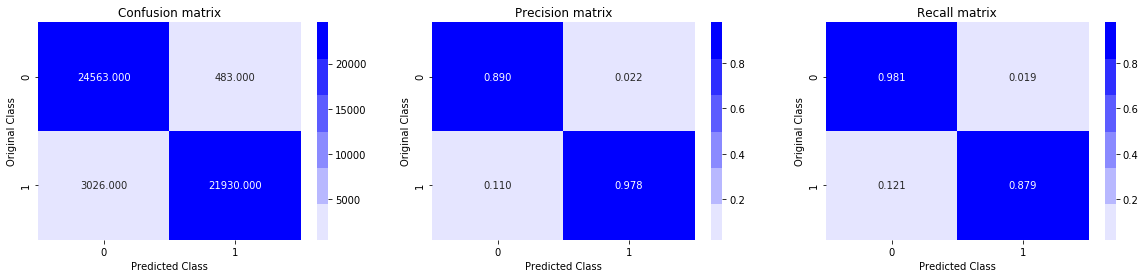

In [249]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

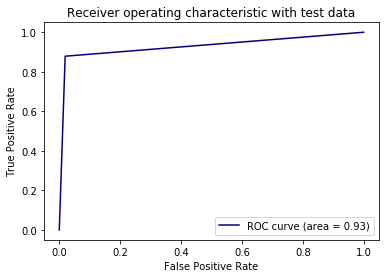

In [250]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

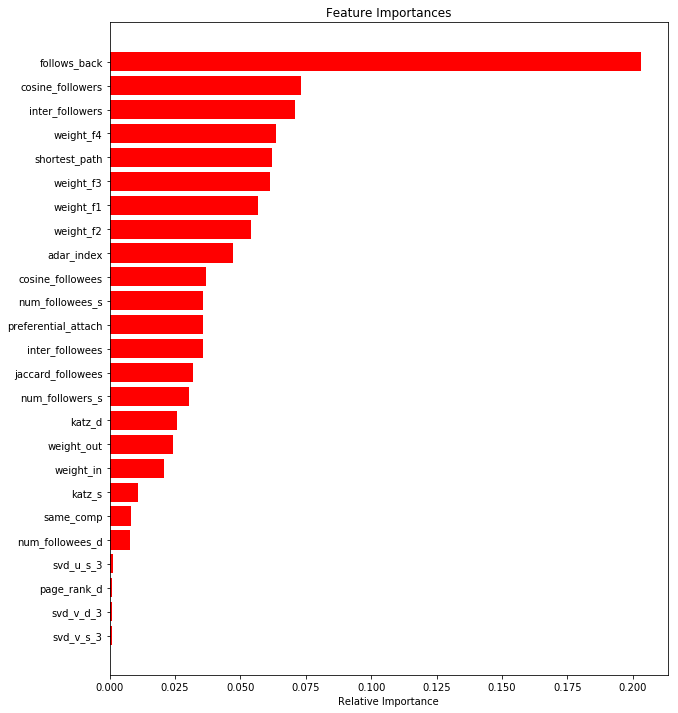

In [254]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# XGBOOST

depth =  1 Train Score 0.9266532059798926 test Score 0.9164077526261282
depth =  3 Train Score 0.9734760636412432 test Score 0.9280552671173367
depth =  5 Train Score 0.9764509436826393 test Score 0.9299408935872719
depth =  9 Train Score 0.9863441044167816 test Score 0.9287562020270557
depth =  10 Train Score 0.9897199360887522 test Score 0.9276001781888379
depth =  12 Train Score 0.9958515371357568 test Score 0.9264052704282223


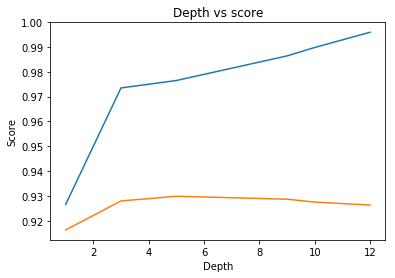

In [257]:
from xgboost import XGBClassifier
depths = [1,3,5,9,10,12]
train_scores = []
test_scores = []
for i in depths:
    clf = XGBClassifier(max_depth=i,n_jobs=-1)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score')
plt.show()

Estimators =  5 Train Score 0.915447536467121 test Score 0.9105991575689848
Estimators =  10 Train Score 0.9210492696844526 test Score 0.9162413689582708
Estimators =  50 Train Score 0.9672936481408329 test Score 0.9244996199645301
Estimators =  100 Train Score 0.9734760636412432 test Score 0.9280552671173367
Estimators =  120 Train Score 0.9741319936798607 test Score 0.926930751921199


Text(0.5, 1.0, 'Estimators vs score')

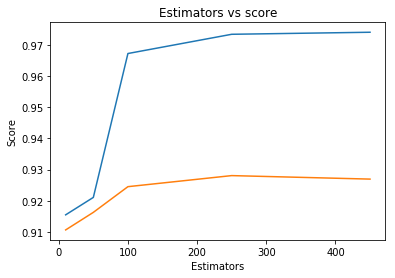

In [259]:
no_of_estimators = [5, 10, 50, 100, 120]
train_scores = []
test_scores = []
for i in no_of_estimators:
    clf = XGBClassifier(n_estimators = i,n_jobs=-1)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score')

In [260]:
param_dist = {"n_estimators":[5,10,50,100,120],
              "max_depth": [1,3,5,9,10,12]}

clf = XGBClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.97970109 0.92974354 0.92083869 0.97364691 0.98042538]
mean train scores [0.99102705 0.92982431 0.92079546 0.97399831 0.99435732]


In [261]:
print(rf_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=120,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=25, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)


Train f1 score 0.9935206916611503
Test f1 score 0.926302819145546
----------------------------------------------------------------------------------------------------
Train confusion_matrix


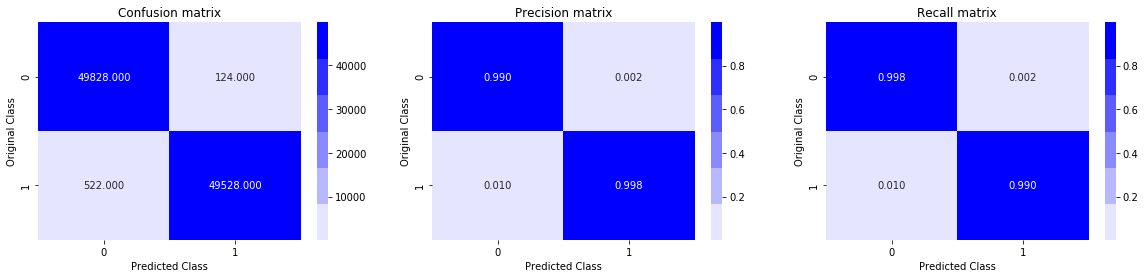

Test confusion_matrix


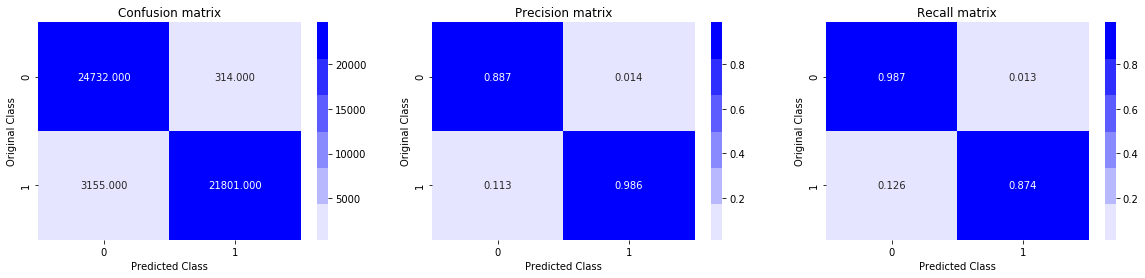

In [262]:
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=120,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=25, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))
print(50*'--')
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

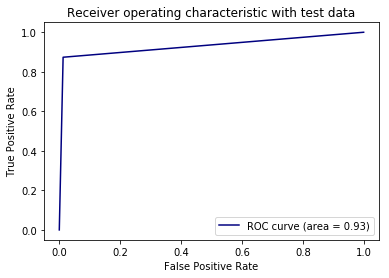

In [263]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

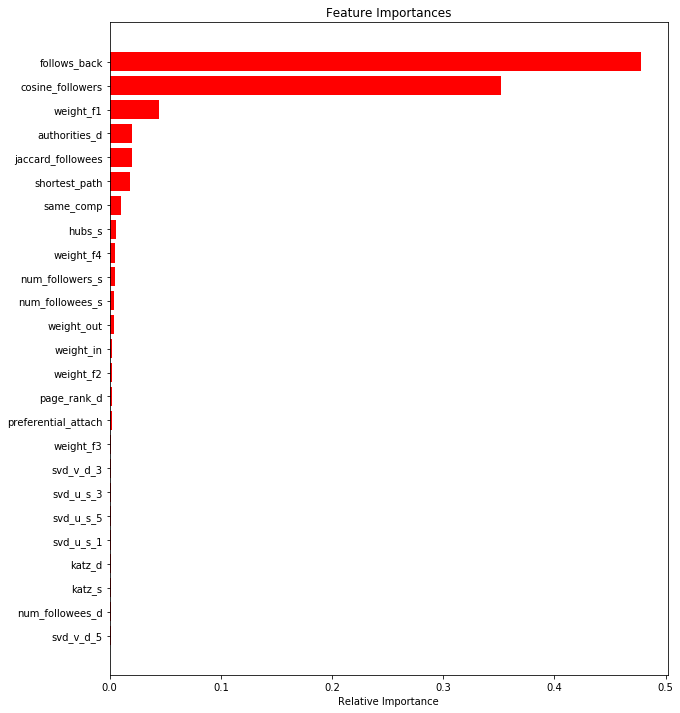

In [264]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Conclusion

*  Our probelem was to given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)
*  We are provided with pairs of node in which a link is present between them.Using that we genrate sevaral features using graph mining techniques.
*  As a part of feature engineering we formed the following features:   'jaccard_followers', 'jaccard_followees', 'cosine_followers',
'cosine_followees', 'num_followers_s', 'num_followees_s', 'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index','follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out','weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s','authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4','svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2','svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1','svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
'preferential_attach', 'dot_u', 'dot_v'

*  We also tried tsne visualization.But it doesnt made much sense.
*  After feature engineering we applies it to machine learning models.We tried random forest and xgboost and both gave us good results.

In [276]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["ML Model","Train f1 score", "Test f1 score"]
x.add_row(["Random Forest",0.9638355662709434,0.9259220165086872])
x.add_row(["XGBoost",0.9935206916611503,0.926302819145546])
print(x)
           
           

+---------------+--------------------+--------------------+
|    ML Model   |   Train f1 score   |   Test f1 score    |
+---------------+--------------------+--------------------+
| Random Forest | 0.9638355662709434 | 0.9259220165086872 |
|    XGBoost    | 0.9935206916611503 | 0.926302819145546  |
+---------------+--------------------+--------------------+
